In [ ]:
# NOT MY OWN CODE : Copied from https://www.allencell.org/cell-shape-analysis.html for personal use 

In [22]:
# Load some supporting packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_context('notebook')
from tqdm import tqdm

In [23]:
!wget https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_cell_segmentations.npz
!wget https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_nuclear_segmentations.npz

cells = np.load("20170919_cell_segmentations.npz")
nucs = np.load("20170919_nuclear_segmentations.npz")
names = cells.keys()
print("We found %i cell segmentations"%len(names))

--2020-04-29 15:32:50--  https://github.com/AllenCellModeling/AllenCellModeling.github.io/raw/master/assets/data/20170919_cell_segmentations.npz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/AllenCellModeling/AllenCellModeling.github.io/master/assets/data/20170919_cell_segmentations.npz [following]
--2020-04-29 15:32:50--  https://media.githubusercontent.com/media/AllenCellModeling/AllenCellModeling.github.io/master/assets/data/20170919_cell_segmentations.npz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.196.133
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73629496 (70M) [application/octet-stream]
Saving to: ‘20170919_cell_segmentations.npz.1’

20170919_cell_seg

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import measure

def plot_volume(volume, ax, zoom=8):
    """Find the mesh for a segmentation and plot it as a surface"""
    verts, faces, normals, values = measure.marching_cubes_lewiner(volume)
    x, y, z = verts.T
    ax.plot_trisurf(x, y, faces, z, lw=0, cmap=plt.cm.Paired)
    ax.set_axis_off()  # look nice with no axes 
    ax.dist = zoom     # how far from axis we want to be
    #ax.set(aspect=1, facecolor="white")

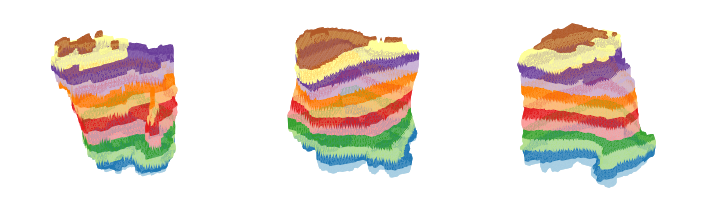

In [35]:
# Now plot our cells
names = list(names)
sample_cells = [cells[name] for name in names[:3]]
fig, axes = plt.subplots(1, 3, figsize=(10,3), subplot_kw={"projection" : "3d"})
for ax, cell in zip(axes, sample_cells):
    plot_volume(cell, ax)
plt.tight_layout()

In [ ]:
from sklearn.decomposition import IncrementalPCA

cell_ipca = IncrementalPCA(n_components=20)
nuc_ipca = IncrementalPCA(n_components=20)

for batch_names in tqdm(np.array_split(names, 100)):
    cell_batch = np.vstack([cells[n].flatten() for n in batch_names])
    nucs_batch = np.vstack([nucs[n].flatten() for n in batch_names])
    cell_ipca.partial_fit(cell_batch)
    nuc_ipca.partial_fit(nucs_batch)

 33%|███▎      | 33/100 [50:50<1:45:41, 94.65s/it]

In [ ]:
# How much variance is explained?
cell_variance = np.cumsum(cell_ipca.explained_variance_ratio_)
nuc_variance = np.cumsum(nuc_ipca.explained_variance_ratio_)
component_number = np.arange(len(cell_variance)) + 1

# Plot variance
fig, axes = plt.subplots(1, 2, figsize=(8,3), sharey=True)
axes[0].plot(component_number, cell_variance)
axes[0].set(ylim=(0,.6), 
            xlabel="n-components", 
            ylabel="Explained variance",
            title="Fraction of cell segmentation\nvariance captured")
axes[1].plot(component_number, nuc_variance)
axes[1].set(xlabel="n-components", 
            title="Fraction of nuclear segmentation\nvariance captured")

plt.tight_layout()

In [ ]:
# Select and prep 1K samples
n = 1000
inds = np.linspace(0,len(names)-1, n, dtype=np.int)
sample_cells = np.reshape([cells[names[i]] for i in inds], (n,-1))
sample_nucs = np.reshape([nucs[names[i]] for i in inds], (n,-1))

# Calculate weights
cell_weights = cell_ipca.transform(sample_cells)
nuc_weights = nuc_ipca.transform(sample_nucs)

In [ ]:
fig, axes = plt.subplots(6, 2, figsize=(8,7), sharex=True)
for i, ax in enumerate(axes[:,0]):
    ax.hist(cell_weights[:,i], 20, (-100,100))
for i, ax in enumerate(axes[:,1]):
    ax.hist(nuc_weights[:,i], 20, (-100,100))
    
axes[0,0].set_title("Component weights for\ncell shape")
axes[0,1].set_title("Component weights for\nnuclear shape")
[ax.set_ylabel("Occur-\nances") for ax in axes[:,0]];
[ax.set_xlabel("Component value") for ax in axes[-1,:]];

plt.tight_layout()

In [ ]:
## Some supporting information first
percentiles = (10,90)
cell_percentiles = np.percentile(cell_weights, percentiles, 0).T
nuc_percentiles = np.percentile(nuc_weights, percentiles, 0).T
original_shape = cells[names[0]].shape
reconstruct = lambda mean, weight, component: 0.05<(mean+weight*component).reshape(*original_shape)

## Reconstruct the cells along the principle components
cells_along_princ_comps = []
for weight, comp in zip(cell_percentiles, cell_ipca.components_):
    cell_lo = reconstruct(cell_ipca.mean_, weight[0], comp)
    cell_hi = reconstruct(cell_ipca.mean_, weight[1], comp)
    cells_along_princ_comps.append([cell_lo, cell_hi])

## Do the same for the nuclei
nucs_along_princ_comps = []
for weight, comp in zip(nuc_percentiles, nuc_ipca.components_):
    nuc_lo = reconstruct(nuc_ipca.mean_, weight[0], comp)
    nuc_hi = reconstruct(nuc_ipca.mean_, weight[1], comp)
    nucs_along_princ_comps.append([nuc_lo, nuc_hi])

In [ ]:
## Cell reconstruction
fig, axes = plt.subplots(6, 4, figsize=(8,14), subplot_kw={"projection":"3d"})
for i, row in enumerate(axes):
    plot_volume(cells_along_princ_comps[i][0], row[0])
    plot_volume(cells_along_princ_comps[i][1], row[1])
    plot_volume(nucs_along_princ_comps[i][0], row[2], 14)
    plot_volume(nucs_along_princ_comps[i][1], row[3], 14)

## Complicated labeling, simple versions don't work with 3d projections
title_props = {'size':'x-large', 'horizontalalignment':'center'}
label_props = {'size':'large', 'horizontalalignment':'center', 'verticalalignment':'center'}
fig.text(.25,.92, "Cell reconstructions", **title_props)
fig.text(.75,.92, "Nuclear reconstructions", **title_props)
for i, x in zip((10,90,10,90), np.linspace(.12,.88,4)):
    fig.text(x,.88,"%ith percentile"%i, **label_props)
for i, y in enumerate(np.linspace(.82,.12,6)):
    fig.text(0,y, "PCA comp %i"%(i+1), rotation='vertical', **label_props)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])